# Replicating paper on $H_2$ ground state

[Use VQE to calculate the ground energy of hydrogen molecules on IBM Quantum](https://arxiv.org/pdf/2305.06538)

> Code doesn't work. I gave up. Sorry


Paper looks very similar to the qiskit tutorial... Also, this paper talks about basics on quantum computing, focusing on basic implementation, not advanced improvement.

Hamiltonian of hydrogen molecule (calculated with Jordan-Wigner transform IN THEORY):

$$
\hat H = -\frac 12 (\hat I \otimes \hat I + \hat X \otimes \hat X + \hat Y \otimes \hat Y + \hat Z \otimes \hat Z ) + d(\hat Z \otimes \hat I + \hat I \otimes \hat Z)
$$



Found either using formulas derived in the qiskit tutorial, or use just database with already calculated hamiltonians (PySCF).

> How?

In [6]:
from qiskit_aqua.drivers import QMolecule

ModuleNotFoundError: No module named 'qiskit._accelerate.circuit'; 'qiskit._accelerate' is not a package

In [1]:
# Code from the paper
# HYDROGEN  MOLECULE INFORMATION
molecule = Molecule(geometry=[["H", [0.0, 0.0, -dist / 2]], ["H", [0.0, 0.0, dist / 2]]], multiplicity=1, charge=0)
driver = ElectronicStructureMoleculeDriver(molecule=molecule, basis="sto3g", driver_type=ElectronicStructureDriverType.PYSCF)
problem = ElectronicStructureProblem(driver, [electronic.FreezeCoreTransformer(freeze_core=True)])

NameError: name 'Molecule' is not defined

In [ ]:
# Code from the paper
# SECOND QUANTIZATION
hamiltonian = problem.second_q_ops()[0]

In [ ]:
# Code from the paper
# JORDAN-WIGNER MAPPING
mapper = JordanWignerMapper()
converter = QubitConverter(mapper, two_qubit_reduction=False)
qubit_op = converter.convert(hamiltonian)


We find that hamiltonian can be represented with Pauli matrices:

> What's the difference between this and the previous representation?

$$
H =  − 0.807184 I ⊗ I ⊗ I ⊗ I + 0.175106 Z ⊗ I ⊗ Z ⊗ I \\
+ 0.169404 I ⊗ Z ⊗ I ⊗ Z \\
− 0.230474 (I ⊗ I ⊗ Z ⊗ I + Z ⊗ I ⊗ I ⊗ I) \\
+ 0.173740 (I ⊗ I ⊗ I ⊗ Z + I ⊗ Z ⊗ I ⊗ I) \\
+ 0.045094 (Y ⊗ Y ⊗ Y ⊗ Y + X ⊗ X ⊗ Y ⊗ Y ) \\
+ 0.045094 (Y ⊗ Y ⊗ X ⊗ X + X ⊗ X ⊗ X ⊗ X) \\
+ 0.166582 (X ⊗ I ⊗ I ⊗ Z + I ⊗ Z ⊗ Z ⊗ I) \\
+ 0.121488 (Z ⊗ Z ⊗ I ⊗ I + I ⊗ I ⊗ Z ⊗ Z)
$$

From the reference [14] in the paper we choose UCCSD as the Ansatz. Initial state |0101> (using Hartree-Fock method).

> What is Hartree-Fock method?

And here is the parameterized circuit

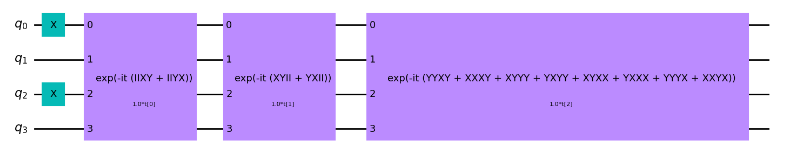

In [ ]:
# Code from the paper
# UCCSD as an ANSATZ, variational form
init_state = HartreeFock(num_spin_orbitals, num_particles, converter)
var_form = UCCSD(converter, num_particles, num_spin_orbitals, initial_state=init_state)

In [ ]:
# Code from the paper
# Getting the backend of IBM Quantum
provider = IBMQ.enable_account(token)
backend = least_busy(provider.backends(filters=lambda x: 
                                        x.configuration().n_qubits >= 6 
                                        and not x.configuration().simulator
                                        and x.status().operational == True))
print("least busy backend: ", backend)

In [ ]:
# Code from the paper
# Use built in VQE algorithm
optimizer = optimizers.L_BFGS_B(maxiter=20)
vqe = VQE(var_form, optimizer, quantum_instance=backend)
vqe_calc = vqe.compute_minimum_eigenvalue(qubit_op)
vqe_result = problem.interpret(vqe_calc).total_energies[0].real

In [ ]:
# Plotting data
